In [1]:
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_FLAGS"] = "--xla_gpu_disable_multi_output_fusion=true"
from threedgnlse import Fiber, InputSource, GNLSE_Sim
import threedgnlse as gnlse
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import matplotlib.animation as animation
from IPython.display import HTML
print("JAX sees these devices:")
for d in jax.devices():
    print(" ", d)


/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


JAX sees these devices:
  cuda:0


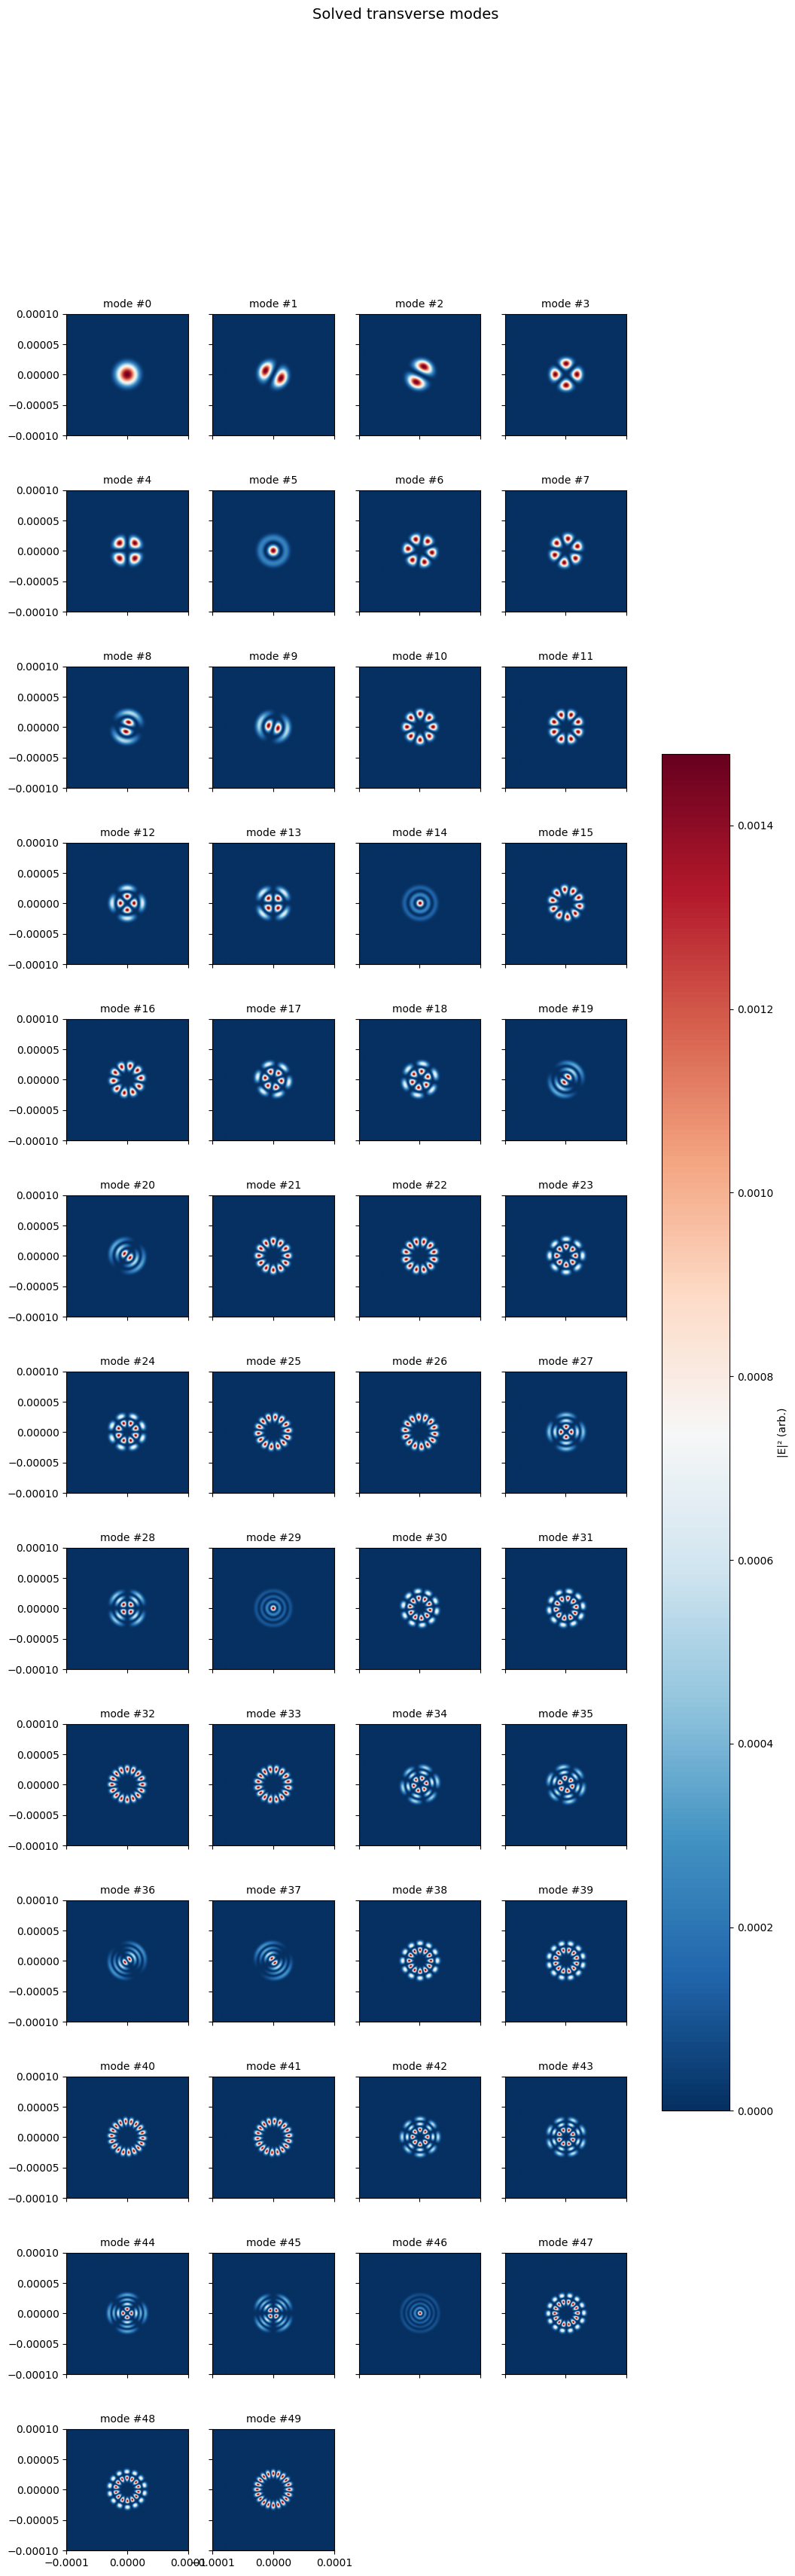

In [2]:
# Grid parameters.
grid_params = {
    "Nx": 200,
    "Ny": 200,
    "Nt": 1,
    "Lx": 200e-6,
    "Ly": 200e-6,
    "T_win": 5e-12
}
dx = grid_params["Lx"]/grid_params["Nx"]
dy = grid_params["Ly"]/grid_params["Ny"]


time_params = {}  # Extend as needed.

# Create Fiber object.
fiber_obj = Fiber(core_radius=40e-6, n_core=1.453, n_clad=1.44,
                  beta0=1.45*2*jnp.pi*3e8/1.064e-6/3e8, beta2=20e-27,
                  gamma=2*8.854e-12*3e8*1.45*2.76e-20, length=0.005,
                  fiber_type='step-index', Lx=200e-6, Ly=200e-6, Nx=200, Ny=200, k0=2*jnp.pi/1.064e-6,
                 transition = "supergaussian",   sg_order   = 5)



modes, betas2 = fiber_obj.solve_modes(num_modes=50, return_eigvals=True)

# 2) take a look
fiber_obj.plot_modes(modes)

Launch power  [W]: 8200000.5


100.00%|███████████████████████████████████████████████| [00:03<00:00, 27.47%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 127.59%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 120.35%/s]


L_sf = 0.0 m
Self‑focusing length: 0.00 mm


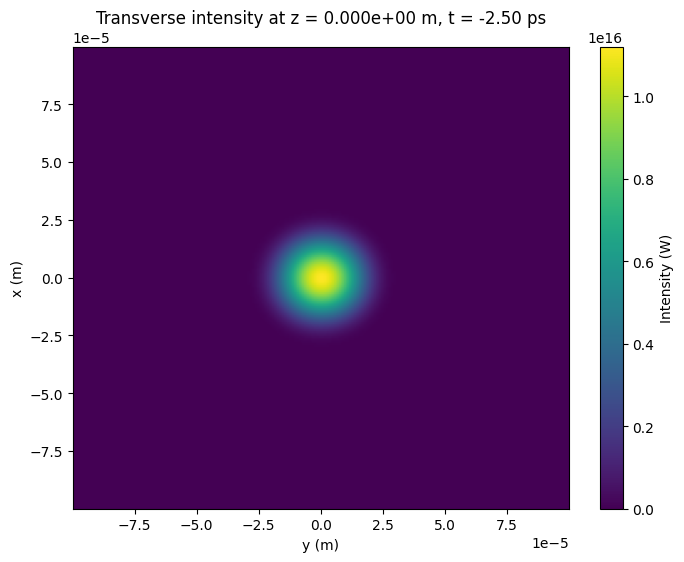

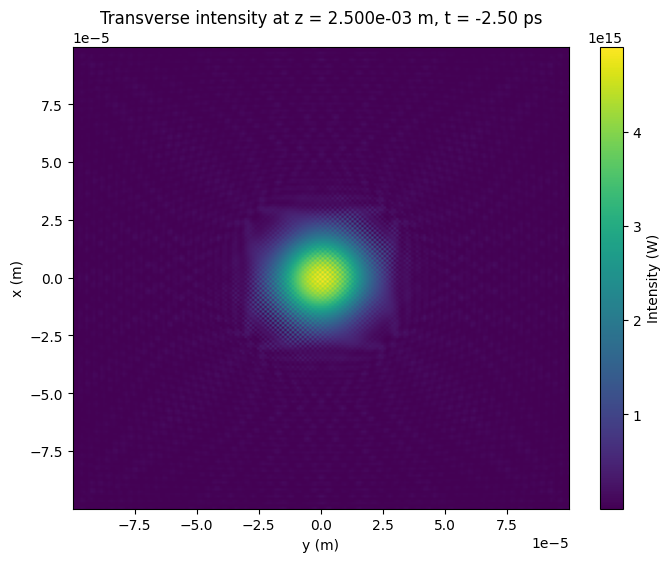

Self‑focusing length (m): [0.00085185]


In [3]:


# 2) Build a custom launch field (50% LP01, 50% LP11 with π/2 phase)
weights = {0: 1.0}
phases  = {0: 0.0}

# build fibre, modes as before …
input_obj = InputSource(source_type="custom")
A0  = input_obj.modal_superposition(
        modes,
        weights=weights,
        phases =phases,
        Nt     = grid_params["Nt"],
        total_power = 8.2e6,     # W
        dx = dx, dy = dy
      )


Pchk = jnp.sum(jnp.abs(A0)**2) * dx * dy
print("Launch power  [W]:", float(Pchk))

z_args = {'z0': 0.0, 'z1':2.5e-3, 'dz_chunk': 1e-3, 'z_res': 1e-3, 'n_save_per_chunk': 1000}
#print( z_args['z0'])

sim = GNLSE_Sim(fiber_obj, input_obj, grid_params, time_params)
z_samples, state_samples = sim.run_propagation(**z_args)
# After propagation has finished
I_peak = np.array([np.abs(sim.reconstruct_field(s, sim.Nx, sim.Ny, sim.Nt)).max()
                   for s in sim.state_samples])

w_of_z = gnlse.effective_radius_vs_z(sim)
L_sf   = gnlse.self_focusing_length(sim.z_samples, w_of_z,
                              method="radius_min", smooth=5)
print("L_sf =", L_sf, "m")


if L_sf is None:
    print("No self‑focusing observed for this input power.")
else:
    print(f"Self‑focusing length: {L_sf*1e3:.2f} mm")

sim.plot_transverse_intensity(z_index=0, t_index=sim.Nt//2)
sim.plot_transverse_intensity(z_index=len(z_samples)-1, t_index=sim.Nt//2)
ani, L_sf = sim.animate_intensity_z_x_vs_t_precomp(return_sfl=True)
print("Self‑focusing length (m):", L_sf)
HTML(ani.to_jshtml())


launch field shape: (200, 200, 1)


100.00%|██████████████████████████████████████████████| [00:00<00:00, 172.42%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 250.88%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 216.66%/s]


L_sf = 0.0 m
Self‑focusing length: 0.00 mm


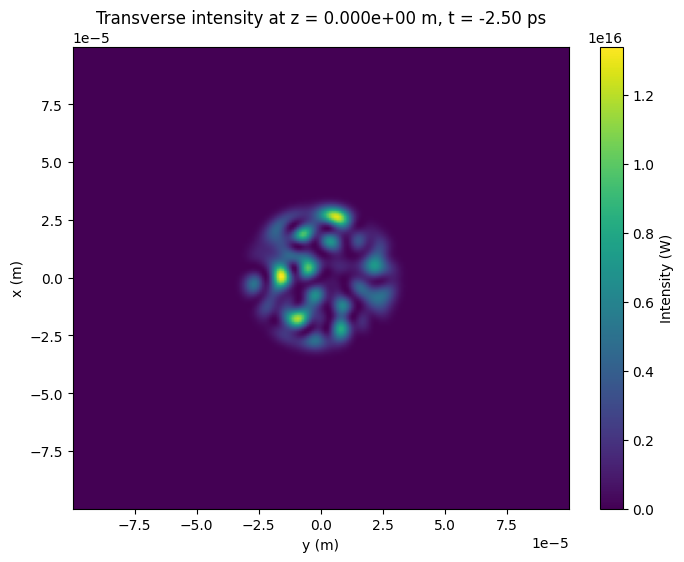

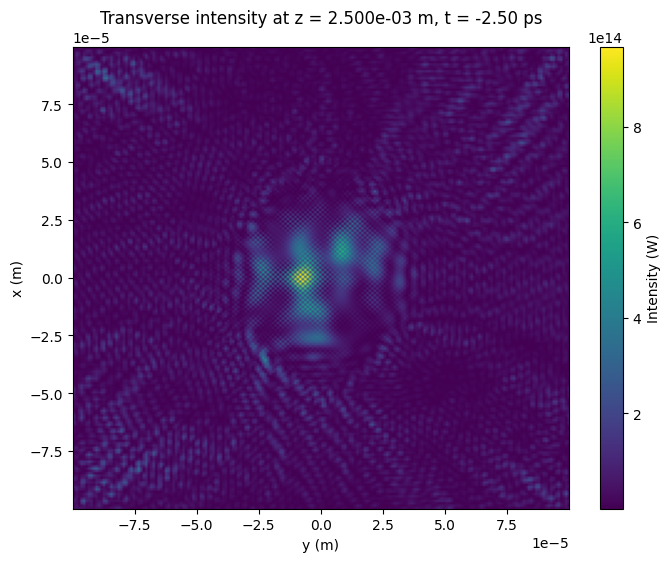

Self‑focusing length (m): [0.00026026]


In [4]:
# modes_arr.shape = (n_modes, Ny, Nx)
rng          = np.random.default_rng(seed=42)

weights = {i: rng.uniform(0.0, 1.0)             for i in range(modes.shape[0])}
phases  = {i: rng.uniform(0.0, 2*np.pi)         for i in range(modes.shape[0])}
mode_dict = {i: jnp.asarray(modes[i])       for i in range(modes.shape[0])}

# ---------- build field  (uses your improved modal_superposition) ---
input_obj = InputSource(source_type="custom")

A0 = input_obj.modal_superposition(
        mode_dict      = mode_dict,
        weights        = weights,
        phases         = phases,
        Nt             = grid_params["Nt"],
        total_power    = 8.2e6,      # [W]  <‑‑ your target power
        dx             = fiber_obj.Lx / fiber_obj.Nx,
        dy             = fiber_obj.Ly / fiber_obj.Ny
     )

print("launch field shape:", A0.shape)        # (Ny,Nx,Nt)

# ---------- continue with simulation ---------------------------------
sim = GNLSE_Sim(fiber_obj, input_obj, grid_params)
z_samples, state_samples = sim.run_propagation(**z_args)

I_peak = np.array([np.abs(sim.reconstruct_field(s, sim.Nx, sim.Ny, sim.Nt)).max()
                   for s in sim.state_samples])

w_of_z = gnlse.effective_radius_vs_z(sim)
L_sf   = gnlse.self_focusing_length(sim.z_samples, w_of_z,
                              method="radius_min", smooth=5)
print("L_sf =", L_sf, "m")


if L_sf is None:
    print("No self‑focusing observed for this input power.")
else:
    print(f"Self‑focusing length: {L_sf*1e3:.2f} mm")

sim.plot_transverse_intensity(z_index=0, t_index=sim.Nt//2)
sim.plot_transverse_intensity(z_index=len(z_samples)-1, t_index=sim.Nt//2)
ani, L_sf = sim.animate_intensity_z_x_vs_t_precomp(return_sfl=True)
print("Self‑focusing length (m):", L_sf)
HTML(ani.to_jshtml())



In [5]:

# Create InputSource object.
fundamental_mode_source = InputSource(power=4.1e6, beam_waist=35e-6, pulse_duration = 0.0, source_type='CW')

# Create simulation object.
sim = GNLSE_Sim(fiber_obj, input_obj, grid_params, time_params)

z_args = {'z0': 0.0, 'z1':2.5e-2, 'dz_chunk': 1e-3, 'z_res': 1e3, 'n_save_per_chunk': 1000}
print( z_args['z0'])
# Run propagation.
z_samples, state_samples = sim.run_propagation(z0=z_args['z0'], z1=z_args['z1'], dz_chunk=z_args['dz_chunk'], z_res=z_args['z_res'],
                                               n_save_per_chunk=z_args['n_save_per_chunk'], diffrax_solver = "Dopri5")

ani, L_sf = sim.animate_intensity_z_x_vs_t_precomp(return_sfl=True)
print("Self‑focusing length (m):", L_sf)
display(HTML(ani.to_jshtml()))

# Animate full transverse intensity vs. z.
#ani2 = sim.animate_transverse_intensity_vs_z(fixed_t_index=sim.Nt//2)

# To display animations in a Jupyter notebook:
#display(HTML(ani1.to_jshtml()))
#display(HTML(ani2.to_jshtml()))


0.0


100.00%|██████████████████████████████████████████████| [00:00<00:00, 171.06%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 254.91%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 213.00%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 205.19%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 198.99%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 191.15%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 182.67%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 178.49%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 182.04%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 180.18%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 179.11%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 178.66%/s]
100.00%|████████████████████

Self‑focusing length (m): [0.00026026]


0.0


100.00%|██████████████████████████████████████████████| [00:00<00:00, 309.71%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 248.82%/s]
100.00%|██████████████████████████████████████████████| [00:00<00:00, 219.70%/s]


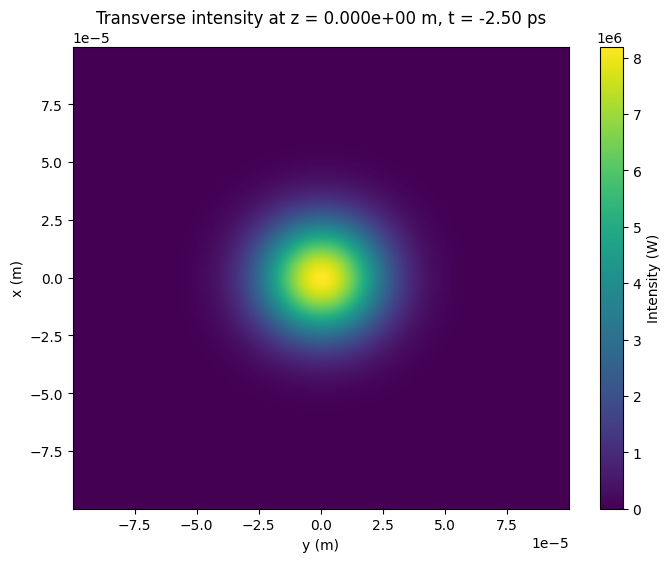

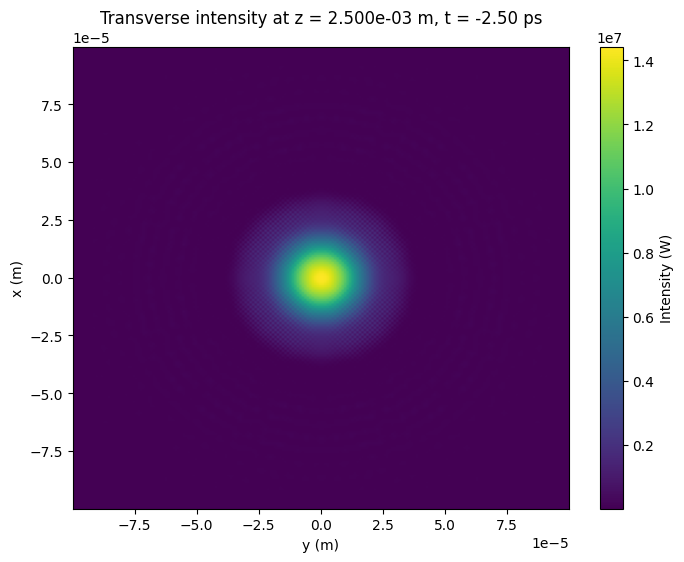

In [6]:

# Grid parameters.
grid_params = {
    "Nx": 200,
    "Ny": 200,
    "Nt": 1,
    "Lx": 200e-6,
    "Ly": 200e-6,
    "T_win": 5e-12
}
time_params = {}  # Extend as needed.

# Create Fiber object.
fiber_obj = Fiber(core_radius=40e-6, n_core=1.453, n_clad=1.44,
                  beta0=1.45*2*jnp.pi*3e8/1.064e-6/3e8, beta2=20e-27,
                  gamma=2*8.854e-12*3e8*1.45*2.76e-20, length=0.005,
                  fiber_type='step-index', Lx=200e-6, Ly=200e-6, Nx=200, Ny=200, k0=2*jnp.pi/1.064e-6)

# Create InputSource object.
input_obj = InputSource(power=8.2e6, beam_waist=35e-6, pulse_duration = 0.0, source_type='CW')

# Create simulation object.
sim = GNLSE_Sim(fiber_obj, input_obj, grid_params, time_params)

z_args = {'z0': 0.0, 'z1':2.5e-3, 'dz_chunk': 1e-3, 'z_res': 1e-4, 'n_save_per_chunk': 100}
print( z_args['z0'])
# Run propagation.
z_samples, state_samples = sim.run_propagation(z0=z_args['z0'], z1=z_args['z1'], dz_chunk=z_args['dz_chunk'], z_res=z_args['z_res'],
                                               n_save_per_chunk=z_args['n_save_per_chunk'], diffrax_solver = "Dopri5")

# Plot a transverse intensity profile.
sim.plot_transverse_intensity(z_index=0, t_index=sim.Nt//2)
sim.plot_transverse_intensity(z_index=len(z_samples)-1, t_index=sim.Nt//2)



# Animate intensity colormap vs. time.
ani1 = sim.animate_intensity_z_x_vs_t_precomp(fixed_y_index=sim.Ny//2, skip_frame=1)
# Animate full transverse intensity vs. z.
#ani2 = sim.animate_transverse_intensity_vs_z(fixed_t_index=sim.Nt//2)

# To display animations in a Jupyter notebook:
display(HTML(ani1.to_jshtml()))
#display(HTML(ani2.to_jshtml()))
